# Graphical models in Python : basics tutorial

## BdM lab
### June 2021
-----------

# Import packages

In [1]:
import pymc3 as pm
import theano.tensor as tt
import theano as theano
import arviz as az
# --------------------
# extras for analysis
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from scipy import stats
import seaborn as sns
from sklearn import linear_model  # packages for the logistic regression function to plot the logistic regression 
from sklearn.linear_model import LogisticRegression # 
from matplotlib import cm
import statsmodels.formula.api as sm

import warnings
warnings.filterwarnings("ignore")

/Users/pradyumna/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/pradyumna/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
def z_score1(data_all,z_score_var, part_def = 0):
    z_matrix=[]
    z_matrix_aux=[]
    
    if part_def==0:
        z_matrix = (data_all[z_score_var] - data_all[z_score_var].mean())/ data_all[z_score_var].std()
    else:
        for i in (data_all[part_def].unique()):
            Choicedata = data_all.loc[data_all[part_def] == i]    
        
            pX_A= pd.to_numeric(Choicedata[z_score_var]) 
            pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)
    
            z_matrix_aux= pX_zA.values
        
            for  j in range(len(z_matrix_aux)):    
                z_matrix.append(z_matrix_aux[j])
    return z_matrix

---------------------
--------------------

 ## Load dataset 

In [3]:
data_all = pd.read_csv('data/DataFoodFramingNotebook_31.csv') 
# restart number of participants to make it sequencial (for )
data_all['Part'] = data_all['Part'].replace(data_all.Part.unique(), list(range(len(data_all.Part.unique()))))
# choose only like trials
data_part_all =  data_all.loc[data_all.BlockCond == 1] 

### Extract relevant variables

In [4]:
data_part_all.columns

Index(['Unnamed: 0', 'Part', 'TrialN', 'PairID', 'LItem', 'LValue', 'RItem',
       'RValue', 'ChosenITM', 'ChoiceRT', 'Conf', 'ConfRT', 'BlockCond',
       'tDDT', 'lIA_DT', 'rIA_DT', 'tGSF', 'lastFixat', 'DV', 'zDV', 'absDV',
       'zAbsDV', 'zConf', 'zChoiceRT', 'DFam', 'LFam', 'RFam', 'TotFam',
       'TotVal', 'FamCh', 'FamUnCh', 'ValCh', 'ValUnCh', 'Correct',
       'LValConfBDM', 'LFamConfBDM', 'RValConfBDM', 'RFamConfBDM', 'zDFam',
       'zTotFam', 'zTotVal', 'zValCh', 'zValUnCh', 'zFamCh', 'zFamUnCh',
       'zGSF', 'zDDT', 'absDDT', 'zAbsDFam', 'zLValue', 'zRValue', 'zLFam',
       'zRFam', 'zLValConfBDM', 'zLFamConfBDM', 'zRValConfBDM', 'zRFamConfBDM',
       'ConfSplit', 'GSFMedSplit', 'DDTMedSplit'],
      dtype='object')

In [5]:
# z-score values
data_part_all['zLValue'] = z_score1(data_part_all,'LValue', 'Part')
data_part_all['zRValue'] = z_score1(data_part_all,'RValue', 'Part')
data_part_all['zAbsDVal'] = z_score1(data_part_all,'absDV', 'Part')
data_part_all['zConf'] = z_score1(data_part_all,'Conf', 'Part')
data_part_all['zRT'] = z_score1(data_part_all,'ChoiceRT', 'Part')
data_part_all['zTotVal'] = z_score1(data_part_all,'TotVal', 'Part')

In [6]:
# load input for models
val_a = data_part_all.zLValue.values
val_b = data_part_all.zRValue.values
absDVal = data_part_all.zAbsDVal.values
totVal = data_part_all.zTotVal.values
chosenByPart = data_part_all.ChosenITM.values
rtByPart = data_part_all.zRT.values
confByPart = data_part_all.zConf.values

In [7]:
confByPart

array([0.36155217, 0.20604586, 0.51705849, ..., 1.1346764 , 1.21099993,
       1.05835288])

In [8]:
rtByPart

array([-0.59904434,  0.28909694, -0.80053895, ..., -0.16099676,
        0.8812454 , -0.98384859])

# 1. Model GLM: confidence ~rt

## generate graphical representation

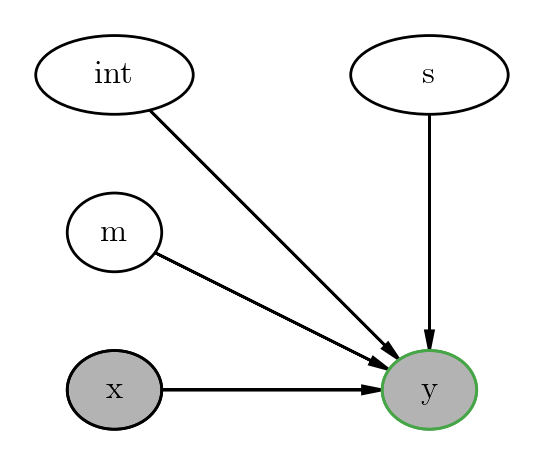

In [9]:
import daft
from matplotlib import rc

rc("font", family="serif", size=12)
rc("text", usetex=True)

# generate nodes for the graphical representation

pgm = daft.PGM()

s_color = {"ec": "#46a546"}

pgm.add_node("sigma", r"s", 5, 2, aspect=2)
pgm.add_node("intercept", r"int", 3, 2, aspect=2)
pgm.add_node("x", r"x", 3, 0, aspect=1.2,observed = True)
pgm.add_node("m", r"m", 3, 1, aspect=1.2)

pgm.add_node("y", r"y", 5, 0, aspect=1.2,observed = True, plot_params=s_color)

# add edges to the graphical model 
pgm.add_edge("sigma", "y", xoffset=-0.1)
pgm.add_edge("intercept", "y", xoffset=-0.1)
pgm.add_edge("m", "y", xoffset=-0.1)
pgm.add_edge("x", "y", xoffset=-0.1)

pgm.render(dpi = 200)
#pgm.savefig("XX.pdf")
#pgm.savefig("PEB_BasicModel_2GenVariance_choice_new.png", dpi=200)


In [10]:
# help(pm.HalfCauchy)

## example: check the priors

In [11]:
with pm.Model() as model00:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    b = pm.Normal("b", 0, sigma=20)

In [12]:
model00

Text(0.5, 1.0, 'Prior distribution for b')

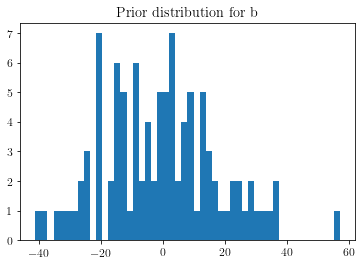

In [13]:
samplesPrior = b.random(size=100)
plt.hist(samplesPrior, bins=50, histtype="stepfilled")
plt.title("Prior distribution for b")
#plt.title("Prior distribution for $\sigma$")

In [14]:
with model00:
    a = pm.Normal('a', 50,sigma = 2 )

In [15]:
model00

Text(0.5, 1.0, 'Prior distribution selected')

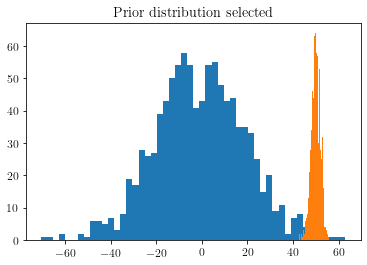

In [16]:
samplesPriorb = b.random(size=1000)
samplesPriora = a.random(size=1000)
plt.hist(samplesPriorb, bins=50, histtype="stepfilled")
plt.hist(samplesPriora, bins=50, histtype="stepfilled")
plt.title("Prior distribution selected")

# define the model

In [17]:
with pm.Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = pm.Normal("Intercept", 0, sigma=20)
    x_coeff = pm.Normal("x", 0, sigma=20)

    #likelihood = pm.Normal("y", mu= mu_d, sigma=sigma, observed=confByPart)
    
    
    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept + x_coeff * rtByPart, sigma=sigma, observed=confByPart)

    # Inference!
    start = pm.find_MAP() # use maximum a posteriori as starting point
    chains = 5

    trace = pm.sample(3000, cores=2,chains = chains, start = start)  # draw 3000 posterior samples using NUTS sampling
    burned_trace = trace[1000::2] 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (5 chains in 2 jobs)
NUTS: [x, Intercept, sigma]


Sampling 5 chains for 1_000 tune and 3_000 draw iterations (5_000 + 15_000 draws total) took 10 seconds.


In [ ]:
burned_trace

# analyze trace

<Figure size 504x504 with 0 Axes>

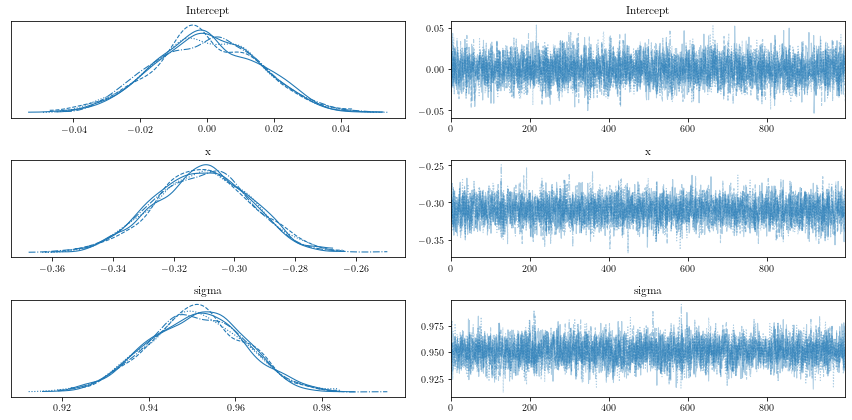

In [18]:
plt.figure(figsize=(7, 7))
pm.traceplot(burned_trace)
plt.tight_layout();

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f83826fcef0>],
      dtype=object)

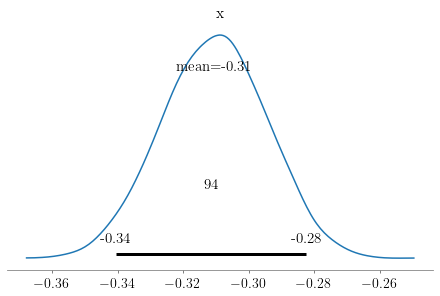

In [19]:
pm.plots.plot_posterior(burned_trace["x"])

In [20]:
rhats_params = az.rhat(burned_trace, method="folded")
rhats_params

<xarray.Dataset>
Dimensions:    ()
Data variables:
    Intercept  float64 1.002
    x          float64 0.9999
    sigma      float64 1.0

## check convergence: rhat<1.05 indicates good convergence

In [21]:
az.summary(burned_trace, round_to=5)  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.00006,0.01580,-0.02883,0.02969,0.00023,0.00018,4620.23458,3650.47133,4610.28798,4502.04892,1.00205
x,-0.31046,0.01575,-0.34052,-0.28234,0.00023,0.00016,4775.62518,4775.62518,4777.21582,4434.75384,1.00021
sigma,0.95096,0.01104,0.93106,0.97163,0.00016,0.00011,4774.58500,4774.58500,4763.89111,4387.72118,1.00045


## check autocorrelation

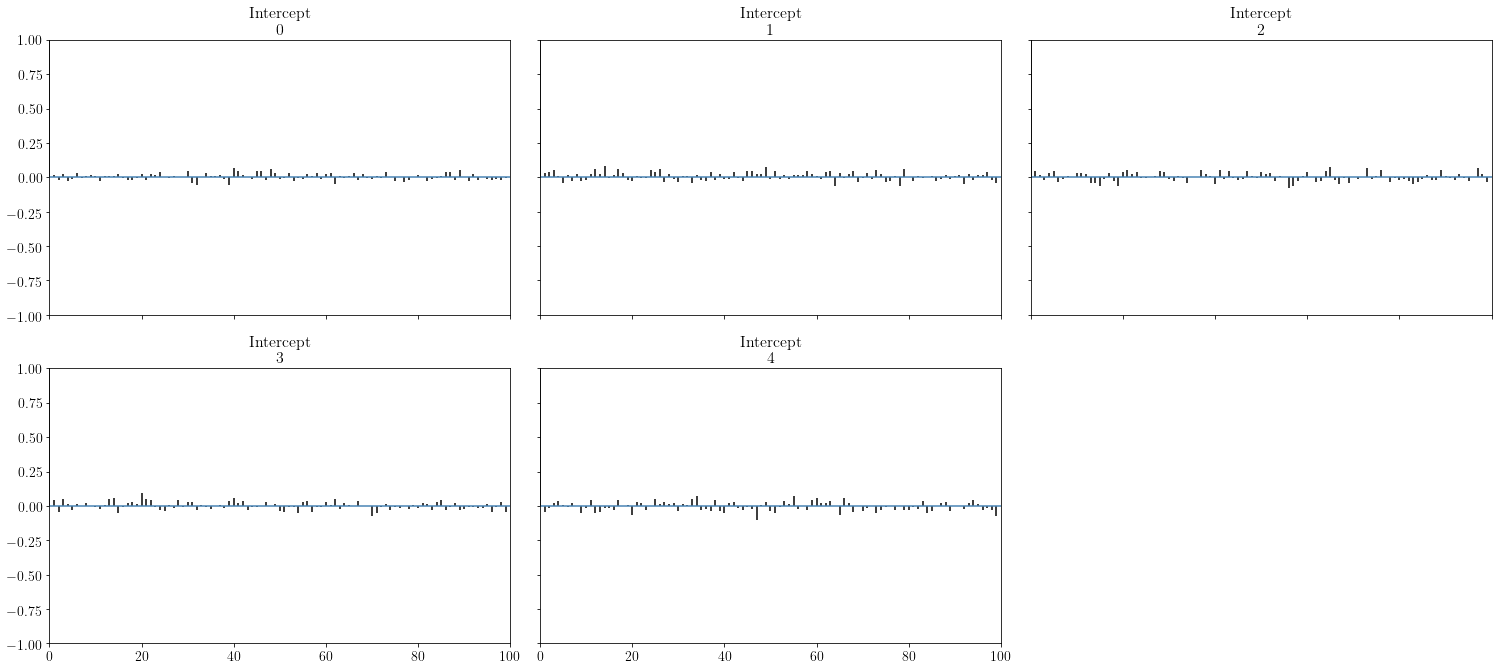

In [22]:
pm.plots.autocorrplot(burned_trace, varnames=["Intercept"]);

## model estimators (for model selection)

In [23]:
pm.waic(burned_trace)
waic1 = pm.waic(burned_trace)

In [24]:
pm.loo(burned_trace)

Computed from 5000 by 3720 log-likelihood matrix

         Estimate       SE
elpd_loo -5093.37    59.02
p_loo        4.67        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [25]:
ppc = pm.sample_posterior_predictive(burned_trace, samples=2000, model=model,var_names = ['x','y','Intercept','sigma'])              #var_names = ['choice]) 

In [26]:
ppc

{'x': array([-0.32424644, -0.3124105 , -0.32245758, ..., -0.30085019,
        -0.30893211, -0.3360869 ]),
 'y': array([[-1.06034214, -1.60447583,  0.98792836, ...,  1.61222459,
          0.99419298,  1.23669481],
        [ 0.62016276, -0.18183629, -0.31488818, ...,  0.26935173,
         -0.09121743, -1.95048042],
        [-0.9028642 ,  0.187662  ,  0.22475323, ..., -0.96100092,
          0.60745928,  0.73550768],
        ...,
        [-1.08662784,  0.19715186,  0.7450356 , ...,  1.63684383,
          0.14720085,  0.40140938],
        [-0.64098216,  0.03626048,  1.78613539, ...,  1.26064713,
         -1.74303468,  0.72998439],
        [-0.18393812, -0.00723755,  0.6307586 , ...,  0.18768832,
         -0.48221013,  1.9030052 ]]),
 'Intercept': array([-0.01834371, -0.02132874,  0.01770928, ..., -0.0199328 ,
        -0.01051675,  0.02912496]),
 'sigma': array([0.96698174, 0.95997499, 0.94994019, ..., 0.93610481, 0.96881351,
        0.961587  ])}

# show data vs posterior samples

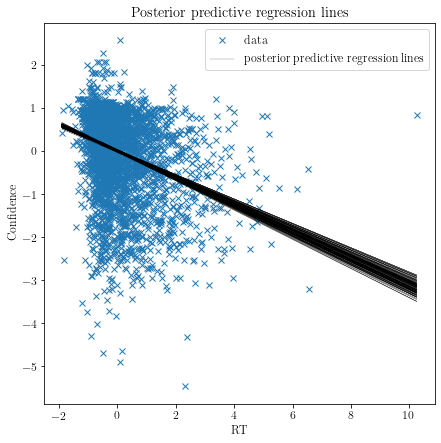

In [27]:
plt.figure(figsize=(7, 7))
plt.plot(rtByPart, confByPart, "x", label="data")
pm.plot_posterior_predictive_glm(burned_trace, samples=100,eval=rtByPart, label="posterior predictive regression lines")
#plt.plot(rtByPart, true_regression_line, label="true regression line", lw=3.0, c="y")

plt.title("Posterior predictive regression lines")
plt.legend(loc=0)
plt.xlabel("RT")
plt.ylabel("Confidence");

 ------------------

## 2. Using "simple" GLM definition in PyMC3


In [ ]:
df1 = pd.DataFrame()
df1['rt'] =rtByPart
df1['conf'] = confByPart

In [ ]:
with pm.Model() as model2:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    pm.glm.GLM.from_formula("conf ~ rt", df1)
    step = pm.Metropolis()
    trace2 = pm.sample(3000, step =step)  # draw 3000 posterior samples using NUTS sampling
    burned_trace2 = trace2[1000::2] 

In [ ]:
az.summary(burned_trace2, round_to=3)

In [ ]:
pm.waic(burned_trace2)


In [ ]:
waic2 = pm.waic(burned_trace2)

In [ ]:
ppc = pm.sample_posterior_predictive(burned_trace2, samples=50, model=model2,var_names = ['Intercept','rt','Intercept','sd'])              #var_names = ['choice]) 

plt.figure(figsize=(7, 7))
plt.plot(rtByPart, confByPart, "x", label="data")
#pm.plot_posterior_predictive_glm(trace2, samples=100, label="posterior predictive regression lines")
for i in range(len(ppc['rt'])):
    plt.plot(rtByPart, ppc['rt'][i]*rtByPart + ppc['Intercept'][i] , label="true regression line", lw=3.0, c="y")

plt.title("Posterior predictive regression lines")
#plt.legend(loc=0)
plt.xlabel("RT")
plt.ylabel("Confidence");

# 3.Simulations/Prediction

In [ ]:
ppc = pm.sample_posterior_predictive(burned_trace, samples=2000, model=model,var_names = ['x','Intercept','sigma'])              #var_names = ['choice]) 

In [ ]:
ppc

In [ ]:
sim_Inter = ppc['Intercept'].mean()
sim_sigma = ppc['sigma'].mean()
sim_x = ppc['x'].mean()

print('Simulated Inter:' + str(sim_Inter))
print('Simulated s:' + str(sim_sigma))
print('Simulated x:' + str(sim_x))


## Using same rt than in training

In [ ]:
with pm.Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define parameters for the simulation
    sigma = sim_sigma
    intercept = sim_Inter
    x_coeff = sim_x

    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept + x_coeff * rtByPart, sigma=sigma, shape = len(rtByPart))

    # sample without fixing observed data
    trace = pm.sample(500, cores=2)  


In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(rtByPart, trace['y'][0] ,'x' , label="sims 1", alpha = 0.2)
plt.plot(rtByPart, trace['y'][1] ,'x' , label="sims 2", alpha = 0.2)
plt.plot(rtByPart, trace['y'][2] ,'x' , label="sims 3", alpha = 0.2)


plt.legend(loc=0)
plt.title("Simulated Data")
plt.xlabel("RT")
plt.ylabel("Confidence");

## Generating random rt 

In [ ]:
rtSims = np.random.uniform(low=-4, high=6, size=(1000))

In [ ]:
with pm.Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define parameters for the simulation
    sigma = sim_sigma
    intercept = sim_Inter
    x_coeff = sim_x

    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept + x_coeff * rtSims, sigma=sigma, shape = len(rtSims))

    # Inference!
    trace = pm.sample(500, cores=2)  # draw 3000 posterior samples using NUTS sampling
    #burned_trace = trace[1000::2] 

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(rtSims, trace['y'][0] ,'x' , label="sims 1", alpha = 0.2)
plt.plot(rtSims, trace['y'][1] ,'x' , label="sims 2", alpha = 0.2)
plt.plot(rtSims, trace['y'][2] ,'x' , label="sims 3", alpha = 0.2)

plt.legend(loc=0)
plt.title("Simulated Data")
plt.xlabel("RT")
plt.ylabel("Confidence");

-----------------------

# 4. defining a hierarchical GLM

In [ ]:
part_names = data_part_all.Part.unique()
part_idx = data_part_all.Part.values
part_idx = part_idx.astype(int)
n_part = len(data_part_all.Part.unique())

In [ ]:
part_names

In [ ]:
part_idx

In [ ]:
part_idx

In [ ]:
n_part

In [ ]:
len(rtByPart)

In [ ]:
len(part_idx)

In [ ]:
len(confByPart)

In [ ]:
part_idx

## model figure

In [ ]:
import daft
from matplotlib import rc

rc("font", family="serif", size=12)
rc("text", usetex=True)

# generate nodes for the graphical representation

pgm = daft.PGM()

s_color = {"ec": "#46a546"}

pgm.add_node("mu_sigma", r"$\mu_s$", 4.5, 3, aspect=1)
pgm.add_node("sd_sigma", r"$\sigma_s$", 5.3, 3, aspect=1)

pgm.add_node("mu_intercept", r"$\mu_{int}$", 3.5, 3, aspect=1)
pgm.add_node("sd_intercept", r"$\sigma_{int}$", 2.5, 3, aspect=1)

pgm.add_node("mu_m", r"$\mu_{m}$", 2, 2.3, aspect=1)
pgm.add_node("sd_m", r"$\sigma_{m}$", 2, 1.7, aspect=1)

pgm.add_node("m", r"m", 3, 1.7, aspect=1.2)
pgm.add_node("sigma", r"s", 5, 2, aspect=1)
pgm.add_node("intercept", r"int", 3, 2.3, aspect=1)
pgm.add_node("x", r"x", 3, 1, aspect=1.2,observed = True)

pgm.add_node("y", r"y", 5, 1, aspect=1.2,observed = True, plot_params=s_color)

# add edges to the graphical model 
pgm.add_edge("m", "y", xoffset=-0.1)

pgm.add_edge('mu_m',"m", xoffset=-0.1)
pgm.add_edge('sd_m',"m", xoffset=-0.1)

pgm.add_edge('mu_sigma',"sigma", xoffset=-0.1)
pgm.add_edge('sd_sigma',"sigma", xoffset=-0.1)

pgm.add_edge('mu_intercept',"intercept", xoffset=-0.1)
pgm.add_edge('sd_intercept',"intercept", xoffset=-0.1)

pgm.add_edge("sigma", "y", xoffset=-0.1)
pgm.add_edge("intercept", "y", xoffset=-0.1)
pgm.add_edge("x", "y", xoffset=-0.1)

pgm.add_plate([2.5,0.3, 3, 2.4], label=r"participants $p$")

pgm.render(dpi = 200)
#pgm.savefig("XX.pdf")


# model specification

In [ ]:
with pm.Model() as model_hier:  # model specifications in PyMC3 are wrapped in a with-statement
    
    # Define priors fix
    mu_intercept = pm.Normal("muIntercept", mu = 0, sigma=100)
    sigma_intercept = pm.HalfNormal("sigmaIntercept", 5.0) 
    
    mu_x_coeff = pm.Normal("muX",mu =  0, sigma=100)
    sigma_x_coeff = pm.HalfNormal("sigmaX", 5.0) 
    
    # Define priors mix
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0) # noise param
    
    intercept = pm.Normal("Intercept", mu = mu_intercept, sigma=sigma_intercept, shape = n_part)
    x_coeff =   pm.Normal("x", mu = mu_x_coeff, sigma=sigma_x_coeff, shape = n_part)

    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept[part_idx] + x_coeff[part_idx] * rtByPart, sigma=sigma, observed=confByPart)

    # Inference!
    trace_hier = pm.sample(3000, cores=2)  # draw 3000 posterior samples using NUTS sampling
    burned_trace_hier = trace_hier[1000::2] 

# analyze trace

In [ ]:
plt.figure(figsize=(7, 7))
pm.traceplot(burned_trace_hier)
plt.tight_layout();

In [ ]:
rhats_params = az.rhat(burned_trace_hier, method="folded")
rhats_params

## check convergence: rhat<1.05 indicates good convergence

In [ ]:
az.summary(burned_trace_hier, round_to=4)

## model estimator (for model comparison)

In [ ]:
pm.waic(burned_trace_hier)
waic_hier = pm.waic(burned_trace_hier)

In [ ]:
waic_hier

In [ ]:
pm.loo(burned_trace_hier)

## generate samples from the posterior

In [ ]:
ppc = pm.sample_posterior_predictive(trace_hier, samples=2000, model=model_hier,var_names = ['x','y','Intercept','sigma'])              #var_names = ['choice]) 

## show relationship data and posterior samples

In [ ]:
ppc = pm.sample_posterior_predictive(burned_trace2, samples=50, model=model2,var_names = ['Intercept','rt','Intercept','sd'])              #var_names = ['choice]) 

plt.figure(figsize=(7, 7))
plt.plot(rtByPart, confByPart, "x", label="data")
#pm.plot_posterior_predictive_glm(trace2, samples=100, label="posterior predictive regression lines")
for i in range(len(ppc['rt'])):
    plt.plot(rtByPart, ppc['rt'][i]*rtByPart + ppc['Intercept'][i] , label="true regression line", lw=3.0, c="y")

plt.title("Posterior predictive regression lines")
#plt.legend(loc=0)
plt.xlabel("RT")
plt.ylabel("Confidence");

# 5. Model comparison -- pooled vs hierarchical

In [ ]:
ysize = 20
ticksize = 20
nticks = 7

fig, ax = plt.subplots(1,1,figsize=(5,8))
sns.set(style='white', font_scale=1.8)

ax.set_facecolor('xkcd:white')
width_bars = 0.4
bars1 = plt.bar([0,1],[ waic1[0], waic_hier[0]], color='#4F6A9A',width = width_bars, hatch = '')

#patterns = ('', '')
plt.ylim(-5700,-4000)
plt.ylabel('WAIC score',fontsize = ysize )
    
# Turn off tick labels
plt.xticks([0,1],['Pooled','Heuristic'],fontsize = 20)
plt.axhline(0, color='black', lw=2, alpha=0.5)
plt.yticks(fontsize=ticksize)
ax.yaxis.set_major_locator(plt.MaxNLocator(nticks))
ax.xaxis.tick_top()

sns.despine()

plt.show()


In [ ]:
df_comp_loo = az.compare({"hierarchical":burned_trace_hier , "pooled":burned_trace },ic="waic")
az.plot_compare(df_comp_loo, insample_dev=False);
df_comp_loo

 ------------------------------

# Additional model: fit to choice

In [ ]:
import daft
from matplotlib import rc

rc("font", family="serif", size=12)
rc("text", usetex=True)

# generate nodes for the graphical representation

pgm = daft.PGM()

s_color = {"ec": "#46a546"}

pgm.add_node("lValue", r"lValue", -0.5, 3, aspect=2)
pgm.add_node("rValue", r"rValue", 3.5, 3, aspect=2)
pgm.add_node("sigmaGen1", r"$\sigma_{bel,l}$", 1.5, 4.2, aspect=1.2)
#pgm.add_node("sigmaGen2", r"$\sigma_{bel,h}$", 1.8, 4.2, aspect=1.2)
pgm.add_node("mu1", r"$\mu_{bel,l}$", 0.6, 3.4, aspect=1.2,observed = True)
pgm.add_node("mu2", r"$\mu_{bel,h}$", 2.4, 3.4, aspect=1.2,observed = True)
pgm.add_node("vl", r"$v_l$", -0.5, 5, aspect=1,observed = True)
pgm.add_node("vr", r"$v_r$", 3.5, 5, aspect=1,observed = True)
pgm.add_node("LLR", r"LLR", 1.5, 3, aspect=1.2)
pgm.add_node("b", r"$\beta$", 0.5, 2.3, aspect=1)
pgm.add_node("p", r"p", 1.5, 2, aspect=1)
pgm.add_node("choice", r"choice", 1.5, 1.2, aspect=2,plot_params=s_color)


# add edges to the graphical model 
pgm.add_edge("vl", "lValue", xoffset=-0.1)
pgm.add_edge("vr", "rValue", xoffset=-0.1)
pgm.add_edge("mu1", "LLR", xoffset=-0.1)
pgm.add_edge("mu2", "LLR", xoffset=-0.1)
pgm.add_edge("sigmaGen1", "LLR", xoffset=-0.1)
#pgm.add_edge("sigmaGen2", "LLR", xoffset=-0.1)
pgm.add_edge("rValue", "LLR", xoffset=-0.1)
pgm.add_edge("lValue", "LLR", xoffset=-0.1)
pgm.add_edge("LLR", "p", xoffset=-0.1)
pgm.add_edge("b", "p", xoffset=-0.1)
pgm.add_edge("p", "choice", xoffset=-0.1)



pgm.render()
#pgm.savefig("XX.pdf")
#pgm.savefig("PEB_BasicModel_2GenVariance_choice_new.png", dpi=200)


## Extract relevant constant for this model

In [ ]:
value_sort = val_a.copy()
value_sort.sort()
value_low = value_sort[:int(len(value_sort)/2)]
value_high = value_sort[int(len(value_sort)/2) + 1 :]

plt.title(r"Distribution of low and high values")
figsize(7, 7)
plt.hist(value_low, bins=10, alpha=0.85,
             label=r"Low Value", color="#7A68A6", normed=True)
plt.hist(value_high, bins=10, alpha=0.85,
             label=r"High Value", color="#F47118", normed=True)
plt.legend()

print ('mean values -> high: '+ str(value_high.mean()) +' ,  low:'+ str(value_low.mean()))
print ('stdev values -> high: '+ str(value_high.std()) +' ,  low:'+ str(value_low.std()))

n_trials = len(val_a)
mu = [value_low.mean(), value_high.mean()]

In [ ]:
val_a

In [ ]:
value_sort

## Version 1

In [ ]:
with pm.Model() as model_choice1:
    # get value for each trial, generate sample for each 
    sigmaBel = pm.Uniform('sigmaBel', lower=0.5, upper=5) # low value distribution
    sigmaSamp = pm.Uniform('sigmaSamp', lower=0.5, upper=5)

    lVal = pm.Normal('lVal', mu = val_a, sigma = sigmaSamp , shape = n_trials)
    rVal = pm.Normal('rVal', mu = val_b, sigma = sigmaSamp  , shape = n_trials)
    
    # estimate odds ratio for the choice of right option
    
    LLR = pm.Deterministic('LLR',  tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(rVal - mu[1] , 2.) / (2 * tt.power(sigmaBel, 2.)))) - 
                                   tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(rVal - mu[0] , 2.) / (2 * tt.power(sigmaBel, 2.)))) + 
                                   tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(lVal - mu[0] , 2.) / (2 * tt.power(sigmaBel, 2.)))) -
                                   tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(lVal - mu[1] , 2.) / (2 * tt.power(sigmaBel, 2.))))  )

    beta = pm.Normal("beta", mu=0, sigma=0.001, testval = 0)
   # alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*LLR)))    
    
    choice = pm.Bernoulli("choice", p, observed=chosenByPart)

    conf = pm.Deterministic('conf',abs(LLR))   
    
    #start = pm.find_MAP()
    step1 = pm.Metropolis()
    
    nchains = 4
    trace_choice1 = pm.sample(3000, step =step1 ,chains= nchains)
    burned_trace_choice1 = trace_choice1[1000::2]    

In [ ]:
az.summary(burned_trace_choice1, round_to=4,var_names=["beta",'sigmaBel','sigmaSamp'] )

In [ ]:
pm.traceplot(burned_trace_choice1, var_names=["beta",'sigmaBel','sigmaSamp'] )

In [ ]:
simHumanBehavPlots (burned_trace_choice1, model_choice1,data_part_all,colorP = ['#4F6A9A','#AFBBD1'])

In [ ]:
pm.waic(burned_trace_choice1)
waic_choice1 = pm.waic(burned_trace_choice1)
waic_choice1

# Version 2

In [ ]:
with pm.Model() as model_choice2:
# get value for each trial, generate sample for each 
    sigmaBel = pm.Uniform('sigmaBel', lower=0.5, upper=5) # low value distribution
    sigmaSamp = pm.Uniform('sigmaSamp', lower=0.5, upper=5)
    
    lVal = pm.Normal('lVal', mu = val_a, sigma = sigmaSamp , shape = n_trials)
    rVal = pm.Normal('rVal', mu = val_b, sigma = sigmaSamp  , shape = n_trials)
    
    # estimate odds ratio for the choice of right option
    
    LLR = pm.Deterministic('LLR',  tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(rVal - mu[1] , 2.) / (2 * tt.power(sigmaBel, 2.)))) - 
                                   tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(rVal - mu[0] , 2.) / (2 * tt.power(sigmaBel, 2.)))) + 
                                   tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(lVal - mu[0] , 2.) / (2 * tt.power(sigmaBel, 2.)))) -
                                   tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(lVal - mu[1] , 2.) / (2 * tt.power(sigmaBel, 2.))))  )

    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*LLR) ))    
    
    choice = pm.Bernoulli("choice", p, observed=chosenByPart)

    start = pm.find_MAP()
    step = pm.Metropolis()
    nchains = 4
    trace_choice2 = pm.sample(3000, step =step ,chains= nchains)
    burned_trace_choice2 = trace_choice2[1000::2]    



In [ ]:
az.summary(burned_trace_choice2, round_to=4,var_names=["beta",'sigmaBel','sigmaSamp'] )

In [ ]:
pm.traceplot(burned_trace_choice2, var_names=["beta",'sigmaBel','sigmaSamp'] )

In [ ]:
simHumanBehavPlots (burned_trace_choice2, model_choice2,data_part_all,colorP = ['#4F6A9A','#AFBBD1'])

In [ ]:
pm.waic(burned_trace_choice2)
waic_choice2 = pm.waic(burned_trace_choice2)
waic_choice2

# Simulations v2

In [ ]:
ppc = pm.sample_posterior_predictive(burned_trace_choice2, samples = 2000, model = model_choice2,var_names = ['sigmaBel','sigmaSamp','beta'])              #var_names = ['choice]) 

In [ ]:
sigmaBel_fit_mean = ppc['sigmaBel'].mean()  
sigmaSamp_fit_mean = ppc['sigmaSamp'].mean()  
beta_fit_mean = ppc['beta'].mean()  

sigmaBel_fit_sd = ppc['sigmaBel'].std()  
sigmaSamp_fit_sd = ppc['sigmaSamp'].std()  
beta_fit_sd = ppc['beta'].std()  

In [ ]:
beta_fit_mean

In [ ]:
beta_fit_sd

In [ ]:
with pm.Model() as model_sims:
# get value for each trial, generate sample for each 
    sigmaBel =  pm.Normal("sigmaBel", mu=sigmaBel_fit_mean, sigma=sigmaBel_fit_sd)
    sigmaSamp =  pm.Normal("sigmaSamp", mu=sigmaSamp_fit_mean, sigma=sigmaSamp_fit_sd)
    
    lVal = pm.Normal('lVal', mu = val_a, sigma = sigmaSamp , shape = n_trials)
    rVal = pm.Normal('rVal', mu = val_b, sigma = sigmaSamp  , shape = n_trials)
    
    # estimate odds ratio for the choice of right option
    
    LLR = pm.Deterministic('LLR',  tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(rVal - mu[1] , 2.) / (2 * tt.power(sigmaBel, 2.)))) - 
                                   tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(rVal - mu[0] , 2.) / (2 * tt.power(sigmaBel, 2.)))) + 
                                   tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(lVal - mu[0] , 2.) / (2 * tt.power(sigmaBel, 2.)))) -
                                   tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(lVal - mu[1] , 2.) / (2 * tt.power(sigmaBel, 2.))))  )

    beta =     pm.Normal("beta", mu=beta_fit_mean, sigma=beta_fit_sd)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*LLR) ))    
    
    choice = pm.Bernoulli("choice", p, shape = n_trials)

    #start = pm.find_MAP()
    step = pm.Metropolis()
    #nchains = 4
    trace_choice_sims = pm.sample(1000, step = step)
    #burned_trace_choice2 = trace_choice2[1000::2]    



In [ ]:
simHumanBehavPlots (trace_choice_sims, model_sims,data_part_all,colorP = ['#4F6A9A','#AFBBD1'])

In [ ]:
ppc = pm.sample_posterior_predictive(trace_choice_sims, samples = 10, model = model_sims,var_names = ['p','choice'])              #var_names = ['choice]) 

In [ ]:
ppc['p']

In [ ]:
ppc['choice']

In [ ]:
val_b - val_a

In [ ]:
ppc = pm.sample_posterior_predictive(trace_choice_sims, samples=10, model=model_sims,var_names = ['choice']) # generates samples from the posterior, im this case the samples consider the 120 trials inputs

posterior_df = pd.DataFrame()
posterior_df['choice'] = ppc['choice'].flatten()
posterior_df['lValue'] = np.tile(val_a, len(ppc['choice']))
posterior_df['rValue'] = np.tile(val_b, len(ppc['choice']))
posterior_df['dValue'] = np.tile(val_b - val_a, len(ppc['choice']))
posterior_df['sumValue'] = np.tile(val_b + val_a, len(ppc['choice']))
posterior_df['absDValue'] = np.tile(np.abs(val_b - val_a), len(ppc['choice']))
RbiggerL = np.tile((val_b>val_a), len(ppc['choice']))
posterior_df['correct'] = RbiggerL == posterior_df['choice']


## FIGURE
logisticplot_simpl ('Simulations', posterior_df, xaxis='dValue', yaxis='choice', ylab='P(Chose Right Item)', xlab='$\Delta$Value',
                  modlowcol='#000000', title='empty',xlim = [-5,5])


plt.show()

    # FIGURE
posterior_df['correct'].value_counts(normalize=1,sort=0).plot(kind='bar',title='Accuracy')
plt.ylabel('proportion')
plt.show()

posterior_df['choice'].value_counts(normalize=1,sort=0).plot(kind='bar',title='Choice right')
plt.ylabel('frquency')
plt.show()


# Appendix - extra functions

In [ ]:
def simHumanBehavPlots (burned_trace, model_peb1,data_part_all_test,colorP = ['#4F6A9A','#AFBBD1']):

    ppc = pm.sample_posterior_predictive(burned_trace, samples=50, model=model_peb1,var_names = ['choice']) # generates samples from the posterior, im this case the samples consider the 120 trials inputs

    posterior_df = pd.DataFrame()
    posterior_df['choice'] = ppc['choice'].flatten()
    posterior_df['lValue'] = np.tile(val_a, len(ppc['choice']))
    posterior_df['rValue'] = np.tile(val_b, len(ppc['choice']))
    posterior_df['dValue'] = np.tile(val_b - val_a, len(ppc['choice']))
    posterior_df['sumValue'] = np.tile(val_b + val_a, len(ppc['choice']))
    posterior_df['absDValue'] = np.tile(np.abs(val_b - val_a), len(ppc['choice']))
    RbiggerL = np.tile((val_b>val_a), len(ppc['choice']))
    posterior_df['correct'] = RbiggerL == posterior_df['choice']
    
    data_part = pd.DataFrame()    
    data_part['choice'] = data_part_all_test.ChosenITM
    data_part['dValue'] = data_part_all_test.zRValue - data_part_all_test.zLValue 
    # z-score participant
    data_part['zAbsDValue'] =  data_part_all_test.zAbsDV.values
    data_part['zSumValue'] = data_part_all_test.zTotVal.values
    # add chosen and unchosen
    data_part['Part'] = data_part_all_test.Part
    
    ## FIGURE
    logisticplot_simpl ('Simulations', posterior_df, xaxis='dValue', yaxis='choice', ylab='P(Chose Right Item)', xlab='$\Delta$Value',
                      modlowcol='#000000', title='empty',xlim = [-5,5])
    
    logisticplot_simplDots ('Human', data_part, xaxis='dValue', yaxis='choice', ylab='P(Chose Right Item)', xlab='$\Delta$Value',
                            meanCol=colorP[0], subjCol = colorP[1], title='empty',xlim = [-5,5])
    
    logisticplot_simpl ('', data_part, xaxis='dValue', yaxis='choice', ylab='P(Chose Right Item)', xlab='$\Delta$Value',
                      modlowcol=colorP[0], title='empty', linewidth = 3 ,xlim = [-5,5])
    
    plt.show()
    
        # FIGURE
    posterior_df['correct'].value_counts(normalize=1,sort=0).plot(kind='bar',title='Accuracy')
    plt.ylabel('proportion')
    plt.show()
    
    posterior_df['choice'].value_counts(normalize=1,sort=0).plot(kind='bar',title='Choice right')
    plt.ylabel('frquency')
    plt.show()


In [ ]:
def logisticplot_simpl (modlow, data, xaxis='zDV', yaxis='G_choice', ylab='P(Chose Reference Item)', xlab='DV (Z-score)',
                  modlowcol='#AAAAAA', title='empty', xlim = [-5,5],linewidth = 5):
    
    sns.set(font_scale=1.5, style='white')
    figsize(5,5)
    
    # defining the sigmoid function
    def model(x):
        y = 1 / (1 + np.exp(-x))
        return y
    
    sub = plt.subplot()


    #run the classifier
    clf = linear_model.LogisticRegression(C=1e5)

    logit_low = {}

    # I think this defines the problem space
    X_test = np.linspace(-10,10,300)

    # fitting the predictive logistic model for the low_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data[xaxis][:, np.newaxis],
            data [yaxis])
    logit_low = model(X_test*clf.coef_ + clf.intercept_).ravel()
    print ('Slope Coef',clf.coef_)
    
    #Plotting the predictive lines
    line_low = sub.plot(X_test, logit_low, color=modlowcol, linewidth=5, label=modlow, zorder=5) 
    
    # Set Labels
    sub.set_ylabel(ylab, fontsize=30)
    sub.set_xlabel(xlab, fontsize=30)

    # Set Ticks
    sub.set_xticks((-5,-3,-1,1,3,5))
    sub.set_yticks((0,0.25,0.5,0.75,1))
    sub.tick_params(axis='both', which='major', labelsize=20)

    # Set Limits
    sub.set_ylim(-0.01, 1.01)
    sub.set_xlim(xlim[0], xlim[1])

    # Set Title
    if title == 'empty':
        sub.set_title('')
    else:
        sub.set_title(title)
    
    sub.legend(frameon=False, prop={'size':20})
    
    sns.despine()

In [ ]:
def logisticplot_simplDots (modlow, data, xaxis='zDV', yaxis='G_choice', ylab='P(Chose Reference Item)', xlab='DV (Z-score)',
                  meanCol='#AAAAAA',subjCol='#000000', title='empty', xlim = [-5,5]):
    
    sns.set(font_scale=1.5, style='white')
    figsize(5,5)
    
    # defining the sigmoid function
    def model(x):
        y = 1 / (1 + np.exp(-x))
        return y
    
    sub = plt.subplot()


    #run the classifier
    clf = linear_model.LogisticRegression(C=1e5)

    logit_low = {}

    # I think this defines the problem space
    X_test = np.linspace(-10,10,300)

    # fitting the predictive logistic model for the low_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data[xaxis][:, np.newaxis],
            data [yaxis])
    logit_low = model(X_test*clf.coef_ + clf.intercept_).ravel()
    print ('Slope coef',clf.coef_)
    
    #      data.groupby(['Part', 'difficulty']).choice.mean()

    
    # generate scatter to plot pariticipants means
    
    levels =  (np.max(data[xaxis]) - np.min(data[xaxis]))/10
    lev_label = np.arange(np.min(data[xaxis]), np.max(data[xaxis]) + levels,levels) 
    
    difficulty2= []
    for i in range(len(data[xaxis].values)):
         difficulty2.append( lev_label[ int((data[xaxis].values[i] - np.min(data[xaxis]) )//levels)] )
            
    data['difficulty'] = np.around(difficulty2, decimals = 3)        
    
    subject_means = data.groupby(['Part', 'difficulty']).choice.mean()
    means = subject_means.groupby('difficulty').mean()
    sems = subject_means.groupby('difficulty').sem()
    
    #Plotting the predictive lines
    #line_low = sub.scatter(X_test, logit_low, color=modlowcol, linewidth=5, label=modlow, zorder=5) 

    # plot subject means
    scatter_data = subject_means.reset_index()
    x_scatter = scatter_data['difficulty'] 
    jittr = np.random.uniform(low=-max(x_scatter)/10,high=max(x_scatter)/10,size=len(scatter_data))/2
    sub.plot(x_scatter+jittr, scatter_data.choice.values, marker='o', ms=5, markerfacecolor=subjCol, color=subjCol,alpha=0.3,linestyle="None")

    # plot mean values
    sub.plot(list(means.index), means.values, 'o', markerfacecolor=meanCol, markersize = 10, fillstyle = 'full',
                    color=meanCol, linewidth=1,label=modlow)
    sub.vlines(list(means.index), means - sems, means + sems,
                      linewidth=1, color= meanCol)
    
    # Set Labels
    sub.set_ylabel(ylab, fontsize=30)
    sub.set_xlabel(xlab, fontsize=30)

    # Set Ticks
    #sub.set_xticks((-5,-3,-1,1,3,5))
    sub.set_yticks((0,0.25,0.5,0.75,1))
    sub.tick_params(axis='both', which='major', labelsize=20)

    # Set Limits
    sub.set_ylim(-0.01, 1.01)
    sub.set_xlim(xlim[0], xlim[1])

    # Set Title
    if title == 'empty':
        sub.set_title('')
    else:
        sub.set_title(title)
    
    sub.legend(frameon=False, prop={'size':20})
    
    sns.despine()

# --------------- END --------------------------